# Bone Age Prediction Project Notebook

Use this report-style notebook to explore the pediatric bone age dataset, trace the complete modeling pipeline, and capture findings as the project evolves. It complements the CLI tools by putting data exploration, training, and evaluation side by side.


## How to use this notebook
1. Start with the environment setup cells to align dependencies with your CLI runs.
2. Work through the dataset exploration sections to understand label distributions and imaging characteristics.
3. Choose the model pipeline you want to run (Global hand CNN, ROI-based models, future variants) and execute the corresponding training/evaluation cells.
4. Annotate the diagnostics and notebook output with observations so the notebook doubles as a living experiment log.


In [ ]:
from pathlib import Path
import sys
import os

PROJECT_ROOT = Path.cwd().resolve()
os.chdir(PROJECT_ROOT)
print(f"Project root: {PROJECT_ROOT}")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

EXPECTED_FILES = ["src", "data"]
missing = [p for p in EXPECTED_FILES if not (PROJECT_ROOT / p).exists()]
if "src" in missing:
    raise FileNotFoundError("Run this notebook from the repository root. Missing file: {missing}")
if "data" in missing:
    import kagglehub
    from kagglehub import KaggleDatasetAdapter
    file_path = PROJECT_ROOT / "data" / "raw"
    kagglehub.download_dataset(KaggleDatasetAdapter.PANDAS, "ipythonx/rsna-bone-age", file_path)

Project root: /home/zeynep/projects/HDA_Project


## Environment setup
Run the cell below to install or refresh project dependencies in the active kernel so every pipeline uses the same environment as scripted runs.


In [2]:
# Run once to install or update project dependencies
%pip install -e .

Obtaining file:///home/zeynep/projects/HDA_Project
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for bone-age-prediction (pyproject.toml) ... done
  Created wheel for bone-age-prediction: filename=bone_age_prediction-0.1.0-0.editable-py3-none-any.whl size=2886 sha256=7c22092aa79cba3b99c6c770507033a778e64fb0004f9e57f41dda393a4f293d
  Stored in directory: /tmp/pip-ephem-wheel-cache-9lb5at_w/wheels/0d/82/98/c9faa42e2a18538be301792c8110f95e16db97a88af17e2e4c
Successfully built bone-age-prediction
  Attempting uninstall: bone-age-prediction
    Found existing installation: bone-age-prediction 0.1.0
    Uninstalling bone-age-prediction-0.1.0:
      Successfully uninstalled bone-age-prediction-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [7]:
from dataclasses import asdict

import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

## Dataset introduction
The pediatric bone age dataset supplies per-patient radiographs plus age and gender metadata. The cells below confirm that the expected CSV splits are present, summarise record counts, and display the first few entries.


In [ ]:
#TODO: if data/raw exists and has files, use it. otherwise 

In [4]:
data_root = PROJECT_ROOT / "data/raw"
train_csv = data_root / "train.csv"
val_csv = data_root / "validation.csv"
test_csv = data_root / "test.csv"

for csv_path in (train_csv, val_csv, test_csv):
    if not csv_path.exists():
        raise FileNotFoundError(f"Expected CSV not found: {csv_path}")

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

print(f"Train records: {len(train_df):,}")
print(f"Validation records: {len(val_df):,}")
print(f"Test records: {len(test_df):,}")

display(train_df.head())

Train records: 12,611
Validation records: 1,425
Test records: 200


,Image ID,male,Bone Age (months)
0,1377,False,180
1,1378,False,12
2,1379,False,94
3,1380,True,120
4,1381,False,82


In [ ]:
from BAP.utils.logger import setup_logging, mirror_keras_stdout_to_file
logger = setup_logging(log_dir=PROJECT_ROOT / "logs")
mirror_keras_stdout_to_file()

from BAP.utils.seeds import set_seeds
set_seeds()

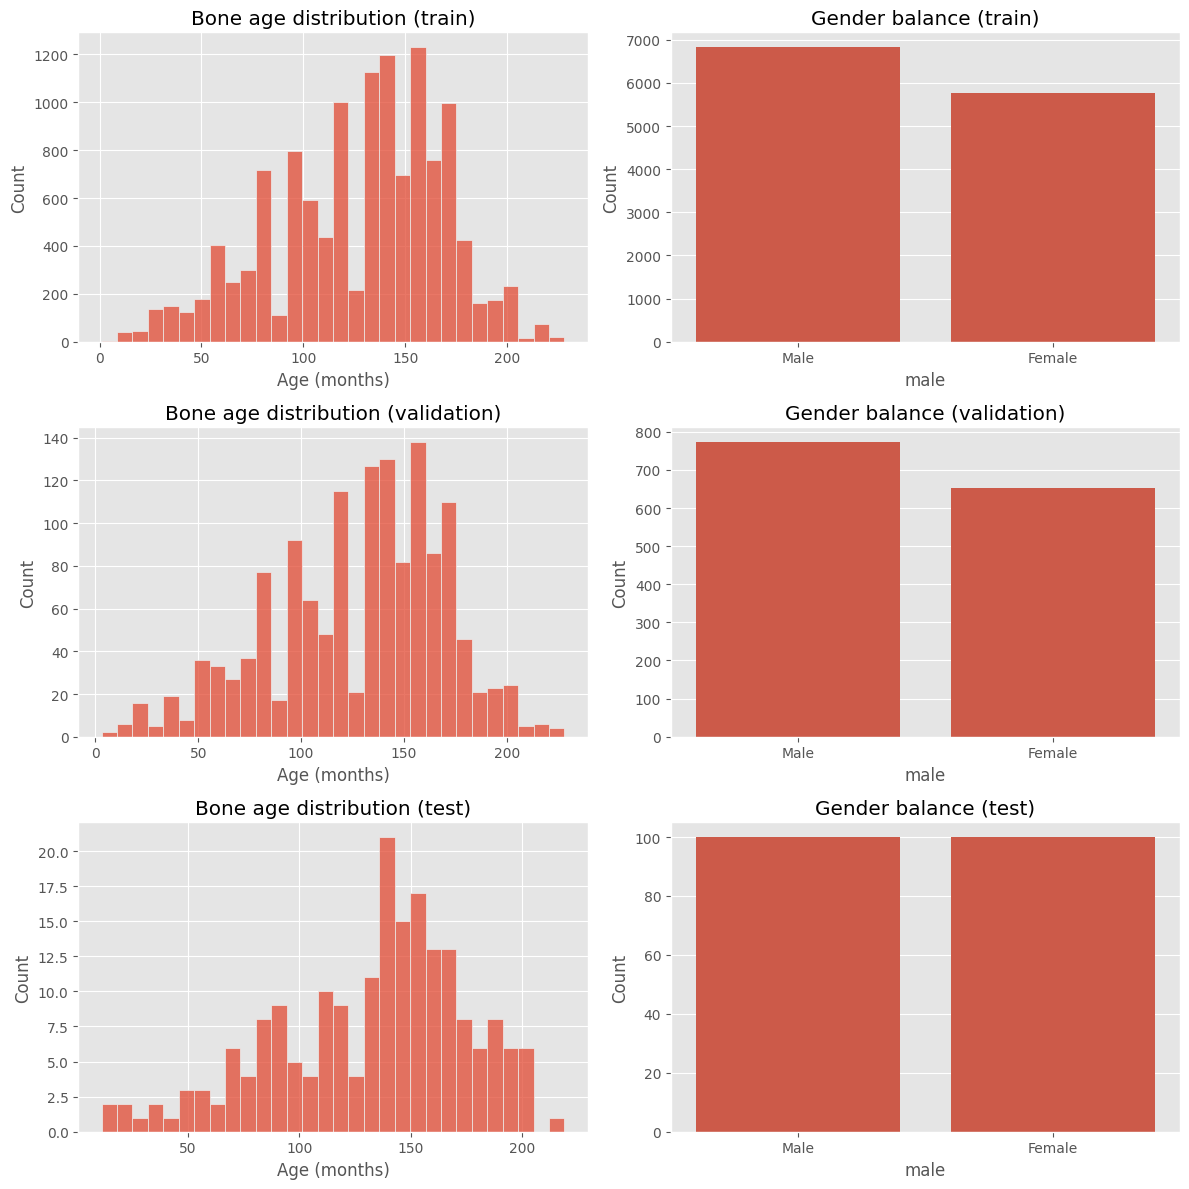

,Image ID,male,Bone Age (months)
count,12611.000000,12611,12611.000000
unique,NaN,2,NaN
top,NaN,True,NaN
freq,NaN,6833,NaN
mean,8537.653001,NaN,127.320752
std,4108.763993,NaN,41.182021
min,1377.000000,NaN,1.000000
25%,5074.500000,NaN,96.000000
50%,8565.000000,NaN,132.000000
75%,12091.500000,NaN,156.000000


,Image ID,male,Bone Age (months)
count,1425.000000,1425,1425.000000
unique,NaN,2,NaN
top,NaN,True,NaN
freq,NaN,773,NaN
mean,8678.919298,NaN,127.156491
std,4123.833964,NaN,41.722011
min,1386.000000,NaN,3.000000
25%,5196.000000,NaN,96.000000
50%,8784.000000,NaN,132.000000
75%,12147.000000,NaN,156.000000


,Image ID,male,Bone Age (months)
count,200.000000,200,200.000000
unique,NaN,2,NaN
top,NaN,True,NaN
freq,NaN,100,NaN
mean,4459.500000,NaN,132.095500
std,57.879185,NaN,43.125336
min,4360.000000,NaN,11.210000
25%,4409.750000,NaN,106.480000
50%,4459.500000,NaN,139.395000
75%,4509.250000,NaN,162.702500


In [21]:
age_col = "Bone Age (months)"
gender_col = "male"

split_frames = [
    ("train", train_df),
    ("validation", val_df),
    ("test", test_df),
]

fig, axes = plt.subplots(len(split_frames), 2, figsize=(12, 4 * len(split_frames)))
if len(split_frames) == 1:
    axes = axes[np.newaxis, :]

gender_map = {True: "Male", False: "Female"}

for row_idx, (split_name, df) in enumerate(split_frames):

    sns.histplot(df[age_col], bins=30, kde=False, ax=axes[row_idx, 0])
    axes[row_idx, 0].set_title(f"Bone age distribution ({split_name})")
    axes[row_idx, 0].set_xlabel("Age (months)")
    axes[row_idx, 0].set_ylabel("Count")

    gender_counts = df[gender_col].map(gender_map).fillna("Unknown").value_counts()
    sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[row_idx, 1])
    axes[row_idx, 1].set_title(f"Gender balance ({split_name})")
    axes[row_idx, 1].set_ylabel("Count")
    axes[row_idx, 1].tick_params(axis='x', labelrotation=0)

plt.tight_layout()
plt.show()

display(train_df[["Image ID", gender_col, age_col]].describe(include="all"))
display(val_df[["Image ID", gender_col, age_col]].describe(include="all"))
display(test_df[["Image ID", gender_col, age_col]].describe(include="all"))


## Example radiographs
Render a handful of preprocessed examples to sanity-check resizing, normalization, and ID/gender metadata before training.


2025-11-07 00:49:47.841227: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 8388752 bytes after encountering the first element of size 8388752 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


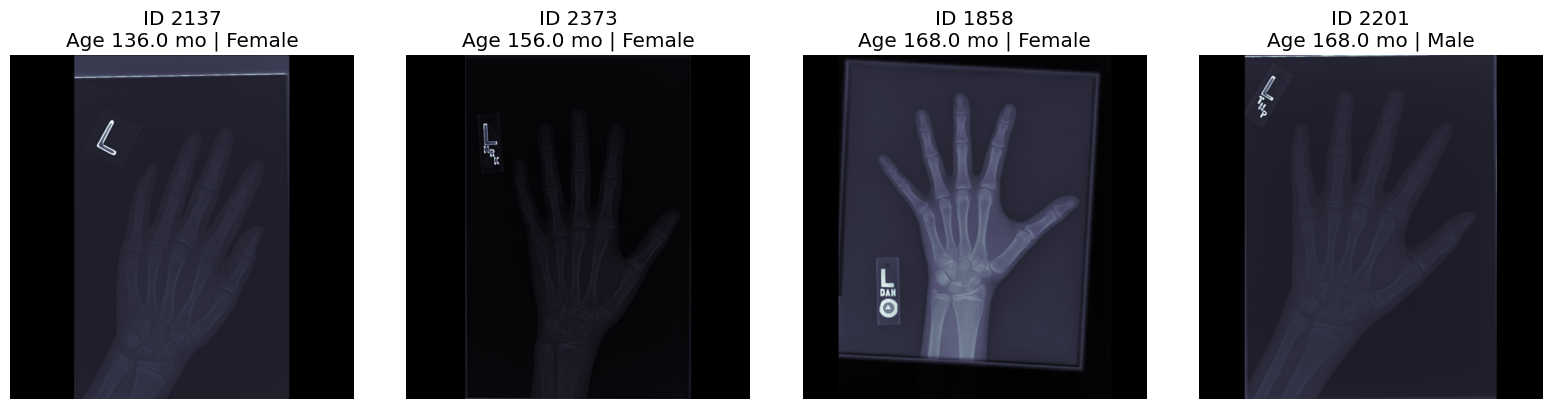

In [19]:
from BAP.utils.dataset_loader import make_dataset

prev_ds = make_dataset(data_path=str(data_root), batch_size=4)

prev_ds = prev_ds.unbatch()
prev_ds = prev_ds.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
prev_ds = prev_ds.batch(4)

sample_features, sample_ages = next(iter(prev_ds.take(1)))
images = sample_features["image_viz"].numpy()
genders = sample_features["gender"].numpy()
ids = sample_features["image_id"].numpy().astype(str)
num_images = images.shape[0]

fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))
if num_images == 1:
    axes = [axes]
ages = sample_ages.numpy()
for ax, img, age, gender, img_id in zip(axes, images, ages, genders, ids):
    ax.imshow(np.squeeze(img), cmap="bone")
    ax.axis("off")
    gender_txt = "Male" if gender == 1 else "Female"
    ax.set_title(f"ID {img_id}\nAge {age:.1f} mo | {gender_txt}")

plt.tight_layout()
plt.show()


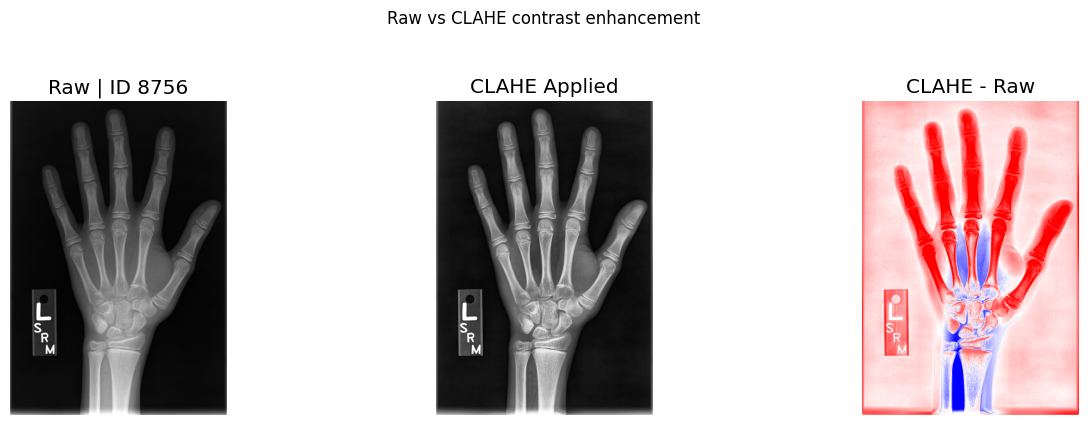

In [ ]:
from BAP.utils.dataset_loader import apply_clahe, id_to_path, read_csv_labels, read_image_grayscale

rows = read_csv_labels(str(data_root / "train.csv"))
id_map = id_to_path(str(data_root / "train"))
sample = random.choice(rows)
image_id = sample["image_id"]
image_path = id_map[image_id]

raw = read_image_grayscale(tf.constant(image_path))
clahe_img = apply_clahe(raw)

raw_np = tf.squeeze(raw, axis=-1).numpy()
clahe_np = tf.squeeze(clahe_img, axis=-1).numpy()
difference = np.clip(clahe_np - raw_np, -1.0, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].imshow(raw_np, cmap="gray")
axes[0].set_title(f"Raw | ID {image_id}")
axes[1].imshow(clahe_np, cmap="gray")
axes[1].set_title("CLAHE Applied")
axes[2].imshow(difference, cmap="bwr", vmin=-0.2, vmax=0.2)
axes[2].set_title("CLAHE - Raw")
for ax in axes:
    ax.axis("off")
fig.suptitle("Raw vs CLAHE contrast enhancement", y=1.05)
plt.tight_layout()
plt.show()


## Model family overview
The repository currently includes a global convolutional network that processes full radiographs (`GlobalCNN`) and an ROI pipeline (`ROI_CNN`) that relies on localized crops. Use this section as a staging area for notes on architectures, training tricks, and evaluation plans for each model variant. Update the accompanying code cells as new models are integrated.


## Model training scaffold
The project exposes multiple training functions (e.g., `train_GlobalCNN` for whole-hand images and `train_ROI_CNN` for cropped regions). Toggle the switches in the code cell to launch the pipeline you need; extend it with additional trainers as new models are added.


In [ ]:
RUN_TRAINING = False  # set to True to launch a run
history = None
model = None

if RUN_TRAINING:
    model, history = train_GlobalCNN(CONFIG_NAME)
else:
    print("Training skipped. Set RUN_TRAINING = True to launch training.")


## Training diagnostics
Plot the captured history metrics (loss, MAE, RMSE) for the most recent run. Add additional visualisations here as new metrics or models come online.


In [ ]:
if history is None:
    print("No training history yet. Run the previous cell to train the model.")
else:
    hist_df = pd.DataFrame(history.history)
    hist_df.index.name = "epoch"
    display(hist_df.tail())

    metric_pairs = [
        ("loss", "val_loss", "Loss"),
        ("mae", "val_mae", "Mean Absolute Error"),
        ("rmse", "val_rmse", "Root Mean Squared Error"),
    ]

    for train_key, val_key, title in metric_pairs:
        if train_key in hist_df and val_key in hist_df:
            plt.figure(figsize=(6, 4))
            plt.plot(hist_df.index + 1, hist_df[train_key], label=f"train {train_key}")
            plt.plot(hist_df.index + 1, hist_df[val_key], label=f"val {val_key}")
            plt.title(title)
            plt.xlabel("Epoch")
            plt.ylabel(title)
            plt.legend()
            plt.grid(True)
            plt.show()

    if "val_mae" in hist_df:
        best_epoch = int(hist_df["val_mae"].idxmin())
        best_row = hist_df.loc[best_epoch]
        print(f"Best epoch (1-indexed): {best_epoch + 1}")
        cols_to_show = [col for col in hist_df.columns if col in ("mae", "rmse", "val_mae", "val_rmse", "val_loss", "loss")]
        display(best_row[cols_to_show])


## Quick validation check
Inspect a validation batch with predictions to perform a fast qualitative review of any trained model. Replace or extend this section with richer evaluation routines (e.g., ROI error analysis) as the project matures.


In [ ]:
if model is None:
    print("Model not available. Train the model first.")
else:
    val_ds = make_dataset(
        data_path=str(data_root),
        split="val",
        target_h=data_cfg.target_h,
        target_w=data_cfg.target_w,
        keep_aspect_ratio=data_cfg.keep_aspect_ratio,
        pad_value=data_cfg.pad_value,
        batch_size=8,
        clahe=data_cfg.clahe,
        augment=False,
        cache=False,
    )
    val_features, val_ages = next(iter(val_ds.take(1)))
    preds = model.predict(val_features["image"], verbose=0).squeeze()

    preview_df = pd.DataFrame({
        "image_id": val_features["image_id"].numpy().astype(str),
        "gender": val_features["gender"].numpy(),
        "age_true": val_ages.numpy(),
        "age_pred": preds,
    })
    preview_df["gender"] = preview_df["gender"].map({1: "Male", 0: "Female"})
    preview_df["error"] = preview_df["age_pred"] - preview_df["age_true"]
    display(preview_df)


## Notes and next steps
- Swap in alternative configs to capture other experiments, and record takeaways directly in the notebook.
- Add dedicated sections for ROI training/evaluation, ensemble comparisons, and error analysis to keep the report comprehensive.
- Link out to generated checkpoints, logs, or external dashboards whenever you expand the workflow.
